In [1]:
import os
import random

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

from functools import partial

import time
import scipy.stats as stats
import seaborn as sns
import arviz as az
import collections

#import constants

#from tqdm import tqdm
from tqdm.auto import tqdm
tqdm.pandas()

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

pd.set_option('display.max_columns', None)

/opt/anaconda3/envs/Boda_2/lib/python3.7/site-packages/tqdm/std.py:702: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [61]:
class constants():
    def __init__(self):
        self.STANDARD_NT = ['A','C','G','T']
        self.DNA_COMPLEMENTS = {'A':'T', 'G':'C', 'T':'A', 'C':'G'}
constants = constants()

class utils():   
    @staticmethod
    def pad_pssm(row, pad_len=24, column_name='pssm'):
        padded_pssm = np.zeros((4, pad_len))
        padded_pssm[:, 0:row['length']] = row[column_name]
        return padded_pssm

    @staticmethod
    def pad_seq_tensor(seq_tensor, pad_len=217, dim=-1):
        assert seq_tensor.shape[dim] <= pad_len
        padded_tensor = torch.zeros((4, pad_len))
        padded_tensor[:, 0:seq_tensor.shape[dim]] = seq_tensor
        return padded_tensor
        
    @staticmethod
    def dna2tensor(sequence_str, vocab_list=constants.STANDARD_NT):
        seq_tensor = np.zeros((len(vocab_list), len(sequence_str)))
        for letterIdx, letter in enumerate(sequence_str):
            seq_tensor[vocab_list.index(letter), letterIdx] = 1
        seq_tensor = torch.Tensor(seq_tensor)
        return seq_tensor

    @staticmethod
    def row_dna2tensor(row, in_column_name='padded_seq' , vocab=['A', 'C', 'G', 'T']):
        sequence_str = row[in_column_name]
        seq_idxs = torch.tensor([vocab.index(letter) for letter in sequence_str])
        sequence_tensor = F.one_hot(seq_idxs, num_classes=4).transpose(1,0)
        return sequence_tensor.type(torch.float32)
    
    @staticmethod
    def append_zero_tensor(row, in_column_name='seq_tensor', target_len=217):
        seq__tensor = row[in_column_name]
        num_zeros = target_len - seq__tensor.shape[-1]
        zeros = torch.zeros((4, num_zeros))
        padded_seq = torch.cat( (seq__tensor, zeros), dim=-1 )
        return padded_seq
    
    @staticmethod
    def reverse_complement_onehot(x, nt_order=constants.STANDARD_NT, 
                              complements=constants.DNA_COMPLEMENTS):
        comp_alphabet = [ complements[nt] for nt in nt_order ]
        permutation = [ nt_order.index(nt) for nt in comp_alphabet ]   
        return torch.flip(x[..., permutation, :], dims=[-1])

    @staticmethod
    def append_zero_tensor(row, in_column_name='seq_tensor', target_len=217):
        seq__tensor = row[in_column_name]
        num_zeros = target_len - seq__tensor.shape[-1]
        zeros = torch.zeros((4, num_zeros))
        padded_seq = torch.cat( (seq__tensor, zeros), dim=-1 )
        return padded_seq

def counts_to_ppm(in_tensor):
    motif = in_tensor.div( in_tensor.sum(0) )
    return motif

def ppm_to_pwm(in_tensor,bkg=[0.25,0.25,0.25,0.25]):
    motif = in_tensor.div(torch.tensor(bkg).unsqueeze(1)).log2()
    return motif

def ppm_to_U(in_tensor):
    return (in_tensor.log2() * in_tensor).sum(0).mul(-1.)

def ppm_to_IC(in_tensor):
    return in_tensor * ppm_to_U( in_tensor ).mul(-1.).add(2.)

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def single_scatterplot(data_df, x_axis, y_axis, color_axis, fig_size=(15,8), dot_size=0.5, title='',
                       dot_alpha=0.5, style='seaborn-whitegrid', colormap='winter',
                       x_label='Experimental', y_label='Predicted', color_label='l2fc SE', title_font_size=18,
                       title_font_weight='medium', axis_font_size=16):
    with plt.style.context(style):
        fig, ax = plt.subplots()    
        data_df.plot(kind='scatter', x=x_axis, y=y_axis, figsize=fig_size, c=color_axis, ax=ax,
                        alpha=dot_alpha, s=dot_size, colormap=colormap)
        plt.xlabel(x_label, fontsize=axis_font_size)
        plt.ylabel(y_label, fontsize=axis_font_size)

        f = plt.gcf()
        cax = f.get_axes()[1]
        cax.set_ylabel(color_label, fontsize=axis_font_size)

        x_min, y_min = data_df[[x_axis, y_axis]].min().to_numpy() 
        x_max, y_max = data_df[[x_axis, y_axis]].max().to_numpy()
        min_point, max_point = min(x_min, y_min), max(x_max, y_max)
        plt.plot((min_point,max_point), (min_point,max_point), color='black', linestyle='--', alpha=0.5)

        Pearson = round(data_df[[x_axis, y_axis]].corr(method='pearson')[x_axis][1], 2)
        Spearman = round(data_df[[x_axis, y_axis]].corr(method='spearman')[x_axis][1], 2)

        #title = f'{title}  |  Pearson={Pearson}  Spearman={Spearman}'
        title = f'{title}  |  Pearson {Pearson}'
        ax.set_title(title, fontdict={'fontsize': title_font_size, 'fontweight': title_font_weight}, pad=15)
        
        ax.tick_params(axis='both', which='major', labelsize=axis_font_size)

def string_to_numpy(text, dtype=None):
    """
    Convert text into 1D or 2D arrays using np.matrix().
    The result is returned as an np.ndarray.
    """
    import re
    text = text.strip()
    # Using a regexp, decide whether the array is flat or not.
    # The following matches either: "[1 2 3]" or "1 2 3"
    is_flat = bool(re.match(r"^(\[[^\[].+[^\]]\]|[^\[].+[^\]])$",
                            text, flags=re.S))
    # Replace newline characters with semicolons.
    text = text.replace("]\n", "];")
    # Prepare the result.
    result = np.asarray(np.matrix(text, dtype=dtype))
    return result.flatten() if is_flat else result

def str2tensor(array_string):
    return torch.tensor([float(item) for item in array_string.lstrip('[[ ').rstrip(' ]]').split(' ') if item != ''])

def ppm_to_IC_alt(in_tensor):
    U = (in_tensor.log2() * in_tensor).sum(dim=1).mul(-1.)
    return in_tensor * U[:, None, :].mul(-1.).add(2.)

def tensor_to_pandas(in_tensor, tokens=constants.STANDARD_NT, colors=['green','orange','red','blue']):
    data = []
    my_array = in_tensor.cpu().numpy()
    for nt, score_vec,color in zip(tokens,[ sub_a for sub_a in my_array ],colors):
         _ = [ data.append([j,nt,score,color]) for j,score in enumerate(score_vec) ]
    return pd.DataFrame(data=data,columns=['site', 'letter', 'height','color'])

def matrix_to_dms(in_tensor, ax=None, y_max=2, fontaspect=.55, widthscale=0.8,
                  axisfontscale=0.6, heightscale=0.8, colors=['green','blue','orange','red']):
    motif = tensor_to_pandas(in_tensor, colors=colors)
    fig, ax = dmslogo.draw_logo(data=motif,
                                x_col='site',
                                letter_col='letter',
                                letter_height_col='height',
                                color_col='color',
                                ax=ax,
                                fixed_ymax=y_max,
                                fontaspect=fontaspect,
                                widthscale=widthscale,
                                axisfontscale=axisfontscale,
                                heightscale=heightscale)
    return fig, ax

def double_pad_seq_tensor(seq_tensor, pad_len=25):
    total_out_len = 2*pad_len + seq_tensor.shape[-1] - 2
    padded_tensor = torch.zeros((4, total_out_len))
    tensor_start = pad_len-1
    tensor_stop = tensor_start + seq_tensor.shape[-1]
    padded_tensor[..., tensor_start:tensor_stop] = seq_tensor
    return padded_tensor

def double_pad_seq_tensor_2(seq_tensor, pad_len=15):
    total_out_len = 2*pad_len + seq_tensor.shape[-1] - 2
    padded_tensor = torch.zeros((seq_tensor.shape[0], seq_tensor.shape[1], total_out_len))
    tensor_start = pad_len-1
    tensor_stop = tensor_start + seq_tensor.shape[-1]
    padded_tensor[..., tensor_start:tensor_stop] = seq_tensor
    return padded_tensor

def align_to_alphabet(in_tensor, in_alphabet=['A','C','G','T'], out_alphabet=constants.STANDARD_NT):
    permuted_idxs = []
    for nt in out_alphabet:
        permuted_idxs.append(in_alphabet.index(nt))
    permutation_idxs = torch.LongTensor(permuted_idxs)
    out_tensor = in_tensor[permutation_idxs, :]
    return out_tensor

def reverse_complement(in_tensor, alphabet=constants.STANDARD_NT):
    rc_dict = {'A':'T', 'G':'C', 'T':'A', 'C':'G'}
    reversed_alphabet = [rc_dict[nt] for nt in alphabet]
    out_tensor = align_to_alphabet(in_tensor, in_alphabet=alphabet,  out_alphabet=reversed_alphabet)
    out_tensor = torch.flip(out_tensor, dims=[1])
    return out_tensor

def show_streme_motifs(parsed_output, num_motifs=None):
    motif_dict = parsed_output['motif_results']
    results_alphabet = parsed_output['meta_data']['alphabet']
    if not num_motifs:
        Range = len(motif_dict)
    else:
        Range = num_motifs
    for motif_idx in range(Range):
        motif_ppm = torch.tensor((motif_dict[motif_idx]['ppm']))
        motif_ppm = align_to_alphabet(motif_ppm, in_alphabet=results_alphabet)
        motif_ppm_rc = reverse_complement(motif_ppm)
        print(motif_dict[motif_idx]['summary'])
        matrix_to_dms(ppm_to_IC(motif_ppm), y_max=2)
        plt.show()
        matrix_to_dms(ppm_to_IC(motif_ppm_rc), y_max=2)
        plt.show()

In [501]:
file_path = '/Users/castrr/Dropbox (JAX)/Datasets/TF_motifs/HOCOMOCO_and_JASPAR_processed_TF_info.txt'

tf_df = pd.read_csv(file_path, sep=' ', low_memory=False)

df_array_columns = ['pfm', 'pwm', 'pwm_rc', 'pssm', 'pssm_rc', 'icm', 'icm_rc', 'padded_pssm', 'padded_pssm_rc']
for df_array_column in tqdm(df_array_columns):
    tf_df[df_array_column] = tf_df.apply(lambda x: string_to_numpy(x[df_array_column]), axis=1)

  0%|          | 0/9 [00:00<?, ?it/s]

In [2]:
boda2_df = pd.read_csv('/Users/castrr/Dropbox (JAX)/Datasets/BODA2/BODA2_MPRA_results_pred_contributions_v3.txt', sep=" ", low_memory=False)
no_controls_df = boda2_df[boda2_df['method'].notnull()].copy().reset_index(drop=True)

In [502]:
target_cell = 'k562'

method_subset = ['fsp'] #['fsp', 'al', 'sa']

quality_filter = (no_controls_df[['K562_lfcSE', 'HepG2_lfcSE', 'SKNSH_lfcSE']].max(axis=1) <= 1.0) 
data_df = no_controls_df[quality_filter].copy().reset_index(drop=True)

data_df = data_df[data_df['method'].isin(method_subset)].reset_index(drop=True)
data_df = data_df[data_df['target_cell'] == target_cell].reset_index(drop=True)

In [503]:
row_filter = (data_df['method'] == 'fsp')
track_info = [a[1] for a in data_df[row_filter]['ID'].str.split('__').tolist() ]

data_df.loc[row_filter, 'penalty_track'] = track_info

In [504]:
data_df['penalty_track'].dropna().unique()

array(['323391', '477844', '730114', '619474', '893131'], dtype=object)

In [505]:
streme_dicts = {}
for root, dirs, files in os.walk('/Users/castrr/Dropbox (JAX)/Datasets/BODA2/fsp_streme_dicts'):
    for file_path in files:
        if target_cell in file_path:
            _, method, cell_type, track_ID, random_tag, round = file_path.split('__')
            if round != 'round_0':
                #track_info = ('__').join([track_ID, random_tag, round.rstrip('.pt')])
                track_info = random_tag + '__' + round.rstrip('.pt')
                print(file_path)
                streme_dicts[track_info] = torch.load(root + '/' + file_path)

streme_penalty__fsp__k562__20211212_085225__619474__round_2.pt
streme_penalty__fsp__k562__20211212_024754__730114__round_5.pt
streme_penalty__fsp__k562__20211212_092818__893131__round_3.pt
streme_penalty__fsp__k562__20211212_024754__730114__round_1.pt
streme_penalty__fsp__k562__20211212_085225__619474__round_3.pt
streme_penalty__fsp__k562__20211212_024754__730114__round_4.pt
streme_penalty__fsp__k562__20211212_092818__893131__round_2.pt
streme_penalty__fsp__k562__20211212_022207__477844__round_5.pt
streme_penalty__fsp__k562__20211212_022207__477844__round_1.pt
streme_penalty__fsp__k562__20211212_022207__477844__round_4.pt
streme_penalty__fsp__k562__20211212_022207__477844__round_3.pt
streme_penalty__fsp__k562__20211212_022207__477844__round_2.pt
streme_penalty__fsp__k562__20211212_024754__730114__round_3.pt
streme_penalty__fsp__k562__20211212_085225__619474__round_4.pt
streme_penalty__fsp__k562__20211212_092818__893131__round_5.pt
streme_penalty__fsp__k562__20211212_092818__893131__rou

Track 477844


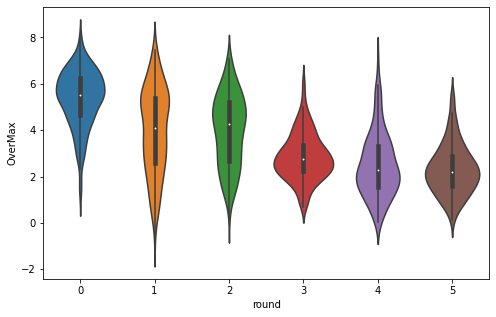


round 1


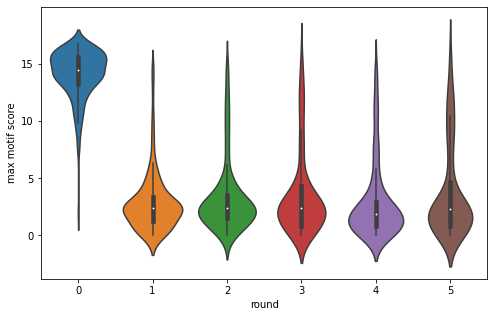


round 2


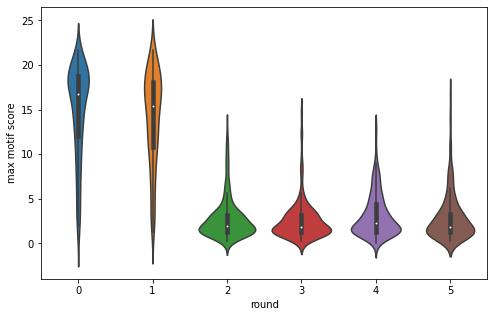


round 3


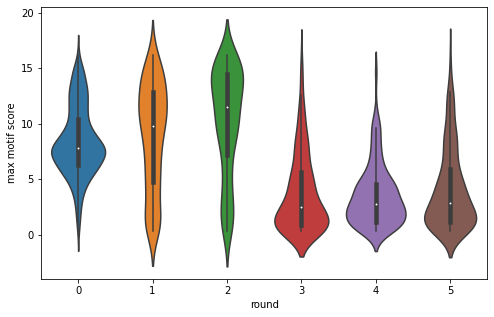


round 4


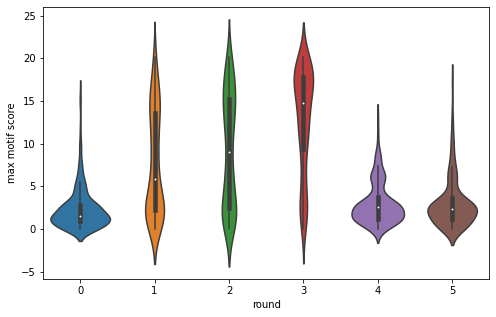


round 5


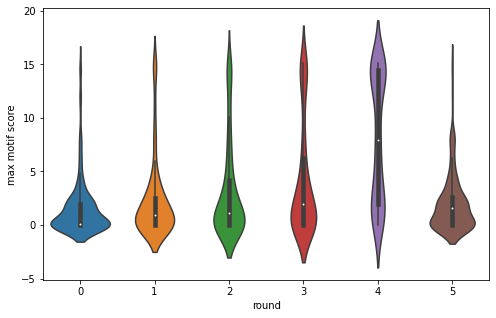



Track 893131


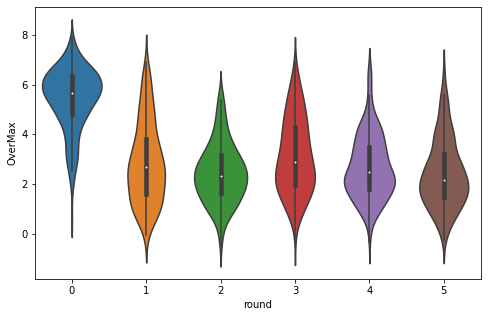


round 1


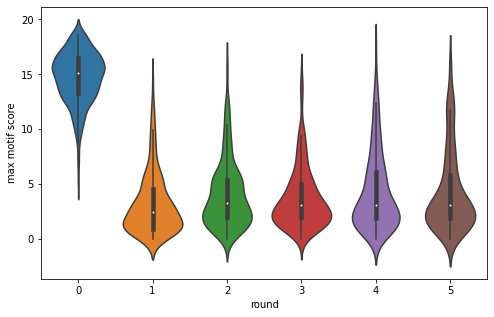


round 2


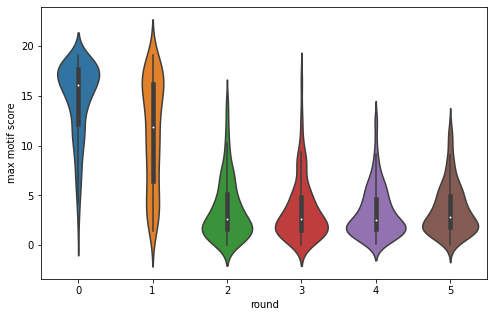


round 3


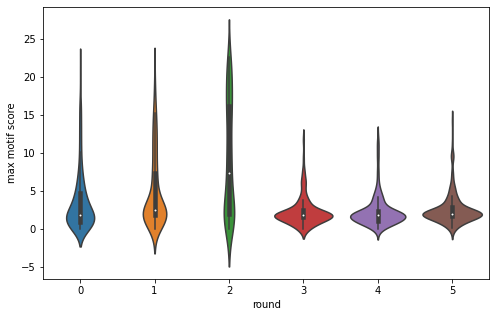


round 4


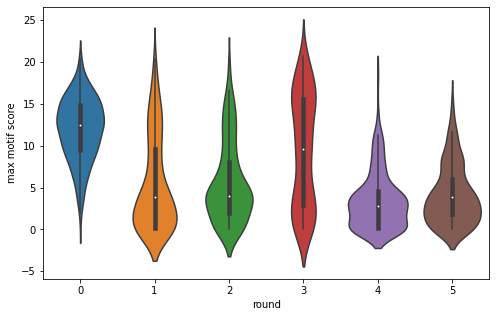


round 5


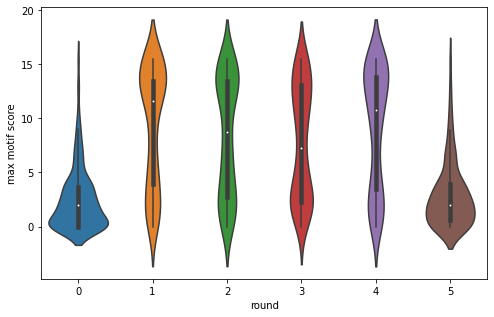



Track 619474


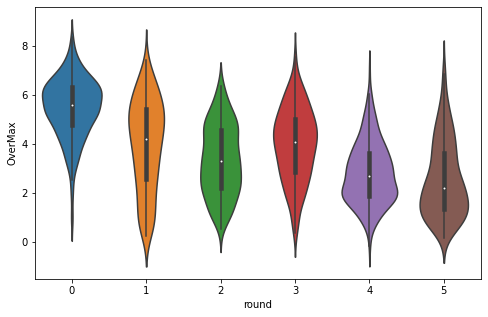


round 1


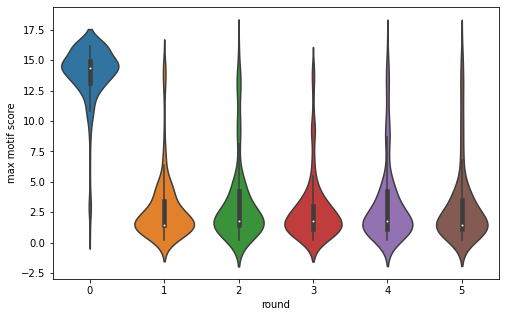


round 2


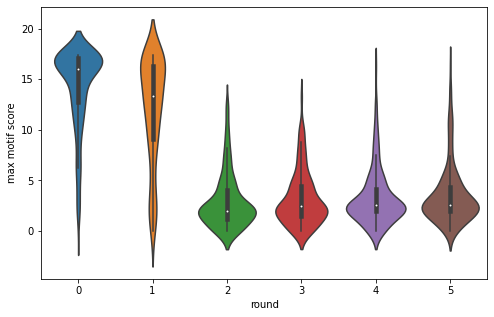


round 3


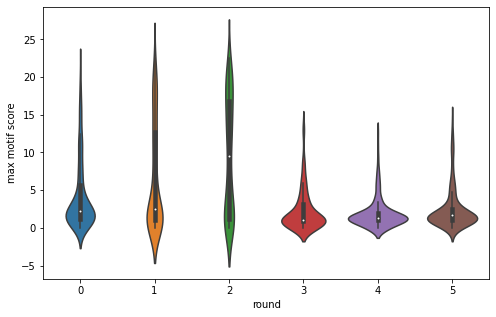


round 4


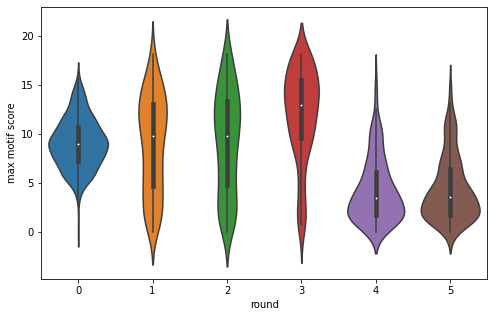


round 5


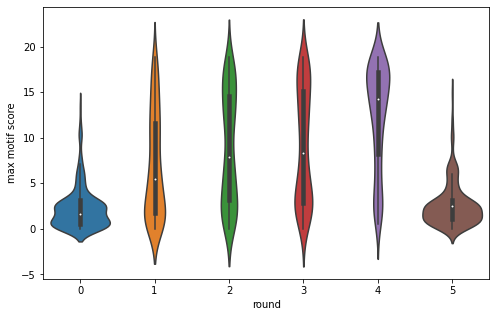



Track 730114


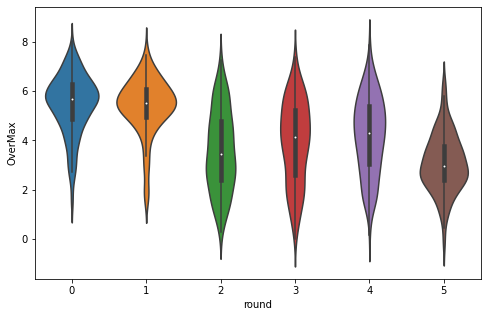


round 1


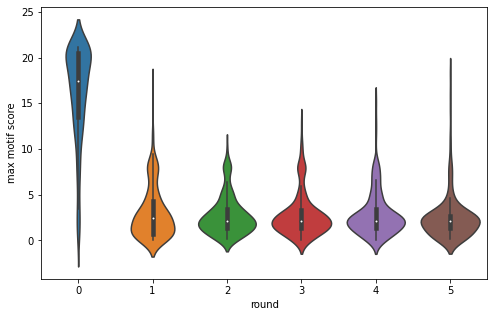


round 2


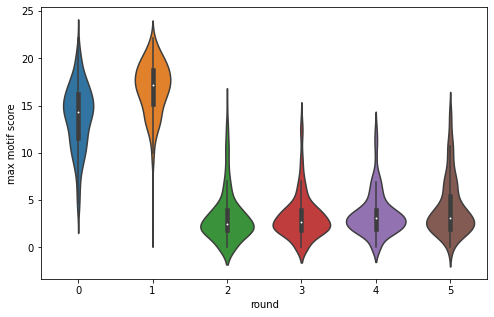


round 3


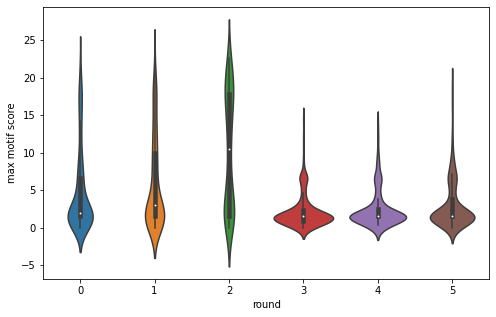


round 4


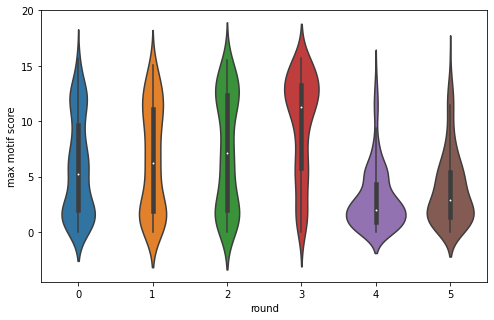


round 5


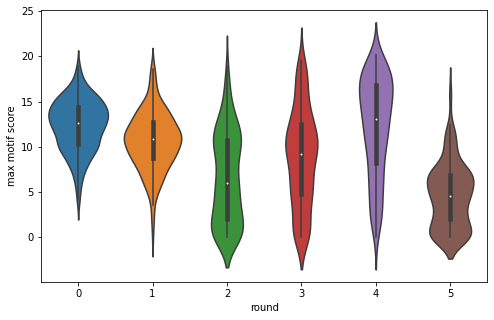

In [506]:
penalty_tracks = list(set([a.split('__')[0] for a in streme_dicts.keys()]))

for penalty_track in penalty_tracks:
    print(f'Track {penalty_track}')
    temp_df = data_df[data_df['penalty_track'] == penalty_track].reset_index(drop=True)
    plt.figure(figsize=(8,5))
    sns.violinplot(data=temp_df, x='round', y='OverMax')
    plt.ylabel('OverMax')
    plt.show()
    print('')

    onehot_sequences = torch.stack([utils.pad_seq_tensor(utils.dna2tensor(seq)) for seq in temp_df['sequence'].tolist()]).type(torch.float32)
    for Round in range(1,6):
        print(f'round {Round}')
        stremed_batch_df = temp_df[temp_df['round'] == Round-1]
        track_key = penalty_track + '__round_' + str(Round)
        penalized_ppm = torch.tensor(streme_dicts[track_key]['motif_results'][0]['ppm'])
        penalized_ppm_rc = reverse_complement(penalized_ppm)
        penalized_pwm = ppm_to_pwm(penalized_ppm)
        penalized_pwm_rc = ppm_to_pwm(penalized_ppm_rc)
        penalized_icm = ppm_to_IC(penalized_ppm)
        penalized_icm_rc = ppm_to_IC(penalized_ppm_rc)

        filters = torch.stack([penalized_pwm, penalized_pwm_rc]).type(torch.float32)

        temp_scores = F.conv1d(onehot_sequences, filters)
        temp_max_scores = torch.max(temp_scores, dim=-1)[0].max(dim=-1)[0]

        temp_df['temp_max_score'] = temp_max_scores.numpy()

        plt.figure(figsize=(8,5))
        sns.violinplot(data=temp_df, x='round', y='temp_max_score')
        plt.ylabel('max motif score')
        plt.show()
        print('')
    print('')

In [507]:
penalty_track = '893131' # sknsh: 199840 817810 958155, k562: 893131

penalized_ppms = []
penalized_ppms_rc = []
penalized_pwms = []
penalized_pwms_rc =[]
penalized_icms = []
penalized_icms_rc = []
for Round in range(1,6):
    track_key = penalty_track + '__round_' + str(Round)
    penalized_ppm = torch.tensor(streme_dicts[track_key]['motif_results'][0]['ppm'])
    penalized_ppm_rc = reverse_complement(penalized_ppm)
    penalized_pwm = ppm_to_pwm(penalized_ppm)
    penalized_pwm_rc = ppm_to_pwm(penalized_ppm_rc)
    penalized_icm = ppm_to_IC(penalized_ppm)
    penalized_icm_rc = ppm_to_IC(penalized_ppm_rc)

    penalized_ppms.append(penalized_ppm)
    penalized_ppms_rc.append(penalized_ppm_rc)
    penalized_pwms.append(penalized_pwm)
    penalized_pwms_rc.append(penalized_pwm_rc)
    penalized_icms.append(penalized_icm)
    penalized_icms_rc.append(penalized_icm_rc)

In [508]:
tf_df[tf_df['name'] == 'MA0482.2']

,name,short_name,length,consensus,pfm,pwm,pwm_rc,pssm,pssm_rc,icm,icm_rc,min_score,max_score,threshold_patser,threshold_fpr,padded_pssm,padded_pssm_rc,database
1121,MA0482.2,GATA4,12,TTCCTTATCTTT,"[[14632.0, 13534.0, 3977.0, 3150.0, 1586.0, 16...","[[0.24794131, 0.22933681, 0.06740317, 0.053390...","[[0.34109933, 0.28279508, 0.81649666, 0.024111...","[[-0.01192946, -0.12446014, -1.89103985, -2.22...","[[0.44826381, 0.17782892, 1.70751889, -3.37414...","[[0.01327891, 0.01145237, 0.03811173, 0.062724...","[[0.01850064, 0.00482094, 0.89751398, 0.040751...",-32.764419,16.147779,7.827936,10.39604,"[[-0.01192946, -0.12446014, -1.89103985, -2.22...","[[0.44826381, 0.17782892, 1.70751889, -3.37414...",JASPAR


290.0%


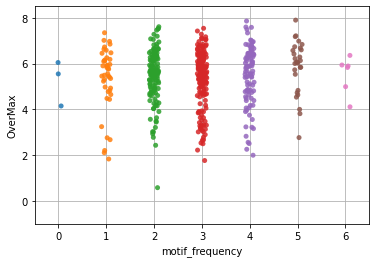

23.0%


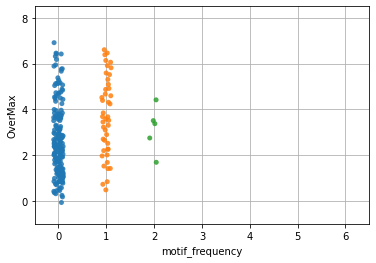

40.0%


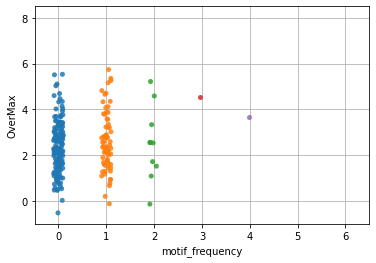

51.0%


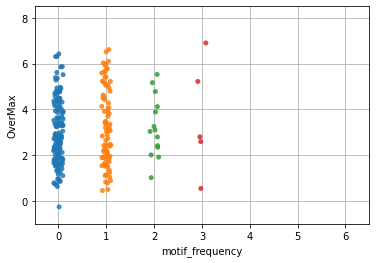

43.0%


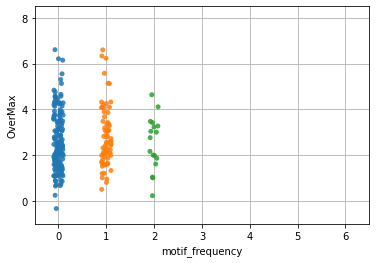

57.0%


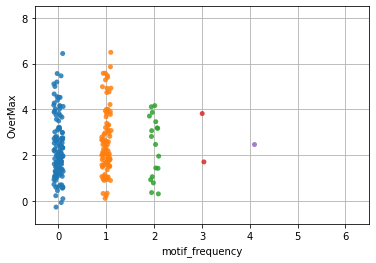

In [509]:
#temp_filters = torch.stack([penalized_pwms[0], penalized_pwms_rc[0]], dim=0).type(torch.float32)

match_motif_idx = 1121
temp_filters = torch.Tensor(np.stack([tf_df.iloc[match_motif_idx]['padded_pssm'], tf_df.iloc[match_motif_idx]['padded_pssm_rc']], axis=0))

score_trheshold = tf_df.iloc[match_motif_idx]['threshold_patser']
max_score = tf_df.iloc[match_motif_idx]['max_score']
overmax_threshold = -3.0

track_df = data_df[(data_df['penalty_track'] == track_id)]
for round_num in range(0, 6):
    track_round_df = track_df[(track_df['round'] == round_num) & (track_df['OverMax'] >= overmax_threshold)].reset_index()
    round_onehot_sequences = torch.stack([double_pad_seq_tensor(utils.dna2tensor(seq), pad_len=temp_filters.shape[-1]) \
                                          for seq in track_round_df['sequence'].tolist()]).type(torch.float32)
    round_scores = F.conv1d(round_onehot_sequences, temp_filters)
    flat_scores = round_scores[round_scores > score_trheshold].flatten().numpy()
    pct_of_intances = np.round(100 * flat_scores.shape[0] / round_onehot_sequences.shape[0])
    print(f'{pct_of_intances}%')
#     plt.hist(flat_scores, bins=100)
#     plt.title(round_num)
#     plt.xlim(score_trheshold-1, max_score+1)
#     plt.show()
    
    motif_frequencies = (round_scores > score_trheshold).sum(dim=-1).sum(dim=-1).flatten().numpy()
#     sns.countplot(x=motif_frequencies, hue_order=list(range(0,6)))
#     plt.title(round_num)
#     plt.show()
    
    track_round_df['motif_frequency'] = list(motif_frequencies)
    sns.stripplot(data=track_round_df, x='motif_frequency', y='OverMax', alpha=.85, order=list(range(7)))
    plt.ylim(-1, 8.5)
    plt.grid()
    plt.show()

In [510]:
tf_df[tf_df['name'] == 'MEIS3_HUMAN.H11MO.0.D']

,name,short_name,length,consensus,pfm,pwm,pwm_rc,pssm,pssm_rc,icm,icm_rc,min_score,max_score,threshold_patser,threshold_fpr,padded_pssm,padded_pssm_rc,database
346,MEIS3_HUMAN.H11MO.0.D,MEIS3,11,TTTGACAGGTG,"[[2342.0, 2104.0, 103.0, 7.0, 9732.0, 7.0, 977...","[[0.236618865, 0.212583317, 0.0105029287, 0.00...","[[0.262573218, 0.665623106, 0.0879620279, 0.10...","[[-0.079363, -0.23389972, -4.57306452, -8.2735...","[[0.07079167, 1.41277742, -1.50697533, -1.2101...","[[0.0112989653, 0.0302086313, 0.0186601455, 0....","[[0.0298217893, 0.374080678, 0.025741617, 0.09...",-49.291245,15.84518,8.614971,10.957535,"[[-0.079363, -0.23389972, -4.57306452, -8.2735...","[[0.07079167, 1.41277742, -1.50697533, -1.2101...",HOCOMOCO


In [511]:
tf_df[tf_df['name'] == 'ZBT14_HUMAN.H11MO.0.C']

,name,short_name,length,consensus,pfm,pwm,pwm_rc,pssm,pssm_rc,icm,icm_rc,min_score,max_score,threshold_patser,threshold_fpr,padded_pssm,padded_pssm_rc,database
663,ZBT14_HUMAN.H11MO.0.C,ZBT14,9,GGAGCGCGC,"[[85.0, 45.0, 325.0, 12.0, 5.0, 6.0, 37.0, 5.0...","[[0.17731959, 0.09484536, 0.67216495, 0.026804...","[[0.09072165, 0.00412371, 0.00412371, 0.012371...","[[-0.49557618, -1.39827898, 1.42688722, -3.221...","[[-1.46240932, -5.92184094, -5.92184094, -4.33...","[[0.03435007, 0.08608399, 0.69727103, 0.043045...","[[0.0741352, 0.00735155, 0.00629877, 0.0215402...",-39.377402,15.258824,7.93506,10.652939,"[[-0.49557618, -1.39827898, 1.42688722, -3.221...","[[-1.46240932, -5.92184094, -5.92184094, -4.33...",HOCOMOCO


In [512]:
tf_df[tf_df['name'] == 'MA0140.2']

,name,short_name,length,consensus,pfm,pwm,pwm_rc,pssm,pssm_rc,icm,icm_rc,min_score,max_score,threshold_patser,threshold_fpr,padded_pssm,padded_pssm_rc,database
1111,MA0140.2,GATA1::TAL1,18,CTTATCTGTGAGGAGCAG,"[[1114.0, 206.0, 318.0, 4955.0, 0.0, 0.0, 2049...","[[0.224843718, 0.0417422868, 0.0643274854, 0.9...","[[0.0729985884, 0.0598911071, 0.000201653559, ...","[[-0.153005515, -2.58234655, -1.9584209, 1.999...","[[-1.77598762, -2.06151439, -10.2758335, -1.44...","[[0.0214506946, 0.0385984577, 0.106147872, 1.9...","[[0.056403351, 0.0998678686, 0.000362692359, 0...",-77.051108,20.664634,11.321404,9.795868,"[[-0.153005515, -2.58234655, -1.9584209, 1.999...","[[-1.77598762, -2.06151439, -10.2758335, -1.44...",JASPAR


In [513]:
tf_df[tf_df['name'] == 'KLF4_HUMAN.H11MO.0.A']

,name,short_name,length,consensus,pfm,pwm,pwm_rc,pssm,pssm_rc,icm,icm_rc,min_score,max_score,threshold_patser,threshold_fpr,padded_pssm,padded_pssm_rc,database
307,KLF4_HUMAN.H11MO.0.A,KLF4,10,AGGGTGTGGC,"[[210.0, 4.0, 1.0, 6.0, 13.0, 2.0, 2.0, 25.0, ...","[[0.41865079, 0.00992063, 0.00396825, 0.013888...","[[0.25, 0.06746032, 0.04960317, 0.5515873, 0.0...","[[0.74381927, -4.65535183, -5.97727992, -4.169...","[[0.0, -1.88981708, -2.33342373, 1.14166115, -...","[[0.14866188, 0.01831974, 0.0074415, 0.0246585...","[[0.14433014, 0.08715179, 0.0644653, 0.5055401...",-50.5812,15.795288,9.337455,10.296605,"[[0.74381927, -4.65535183, -5.97727992, -4.169...","[[0.0, -1.88981708, -2.33342373, 1.14166115, -...",HOCOMOCO


In [528]:
match_motif_ids = ['MA0482.2',
                   'MEIS3_HUMAN.H11MO.0.D',
                   'ZBT14_HUMAN.H11MO.0.C',
                   'MA0140.2',
                   'KLF4_HUMAN.H11MO.0.A'                 
                  ]
match_motif_idxs = [tf_df[tf_df['name'] == motif_id].index.item() for motif_id in match_motif_ids]
match_motif_idxs

[1121, 346, 663, 1111, 307]

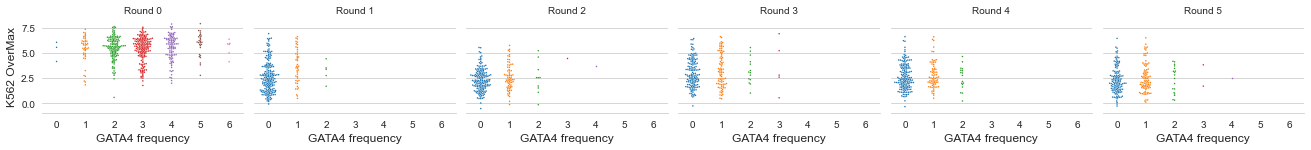

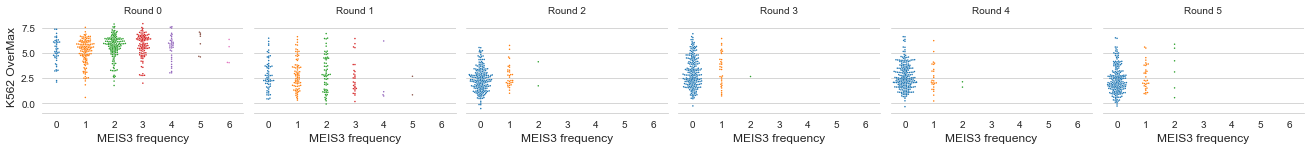

/opt/anaconda3/envs/Boda_2/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 9.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


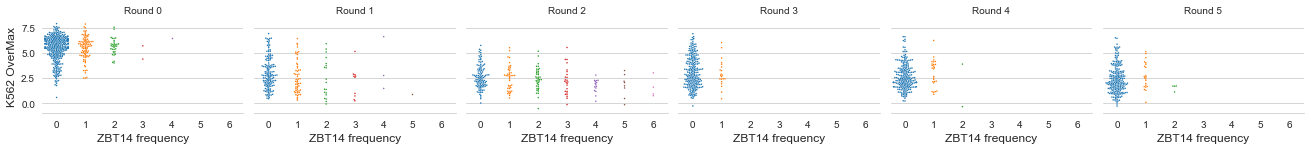

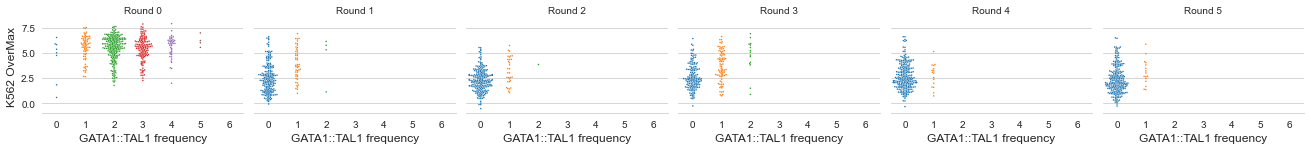

/opt/anaconda3/envs/Boda_2/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 19.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


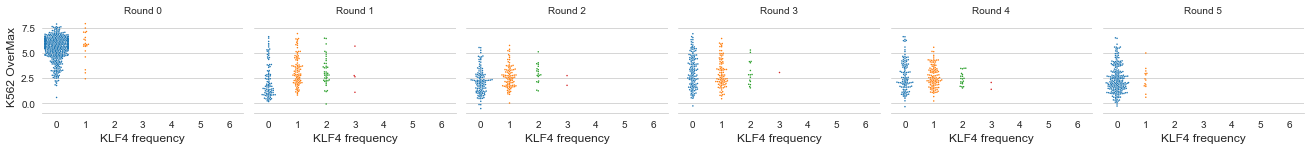

In [533]:
match_motif_ids = ['MA0482.2',
                   'MEIS3_HUMAN.H11MO.0.D',
                   'ZBT14_HUMAN.H11MO.0.C',
                   'MA0140.2',
                   'KLF4_HUMAN.H11MO.0.A'                 
                  ]
match_motif_idxs = [tf_df[tf_df['name'] == motif_id].index.item() for motif_id in match_motif_ids]

for match_motif_idx in match_motif_idxs:
    motif_name = tf_df.iloc[match_motif_idx]['short_name']
    temp_filters = torch.Tensor(np.stack([tf_df.iloc[match_motif_idx]['padded_pssm'], tf_df.iloc[match_motif_idx]['padded_pssm_rc']], axis=0))

    score_trheshold = tf_df.iloc[match_motif_idx]['threshold_patser']
    max_score = tf_df.iloc[match_motif_idx]['max_score']

    track_df = data_df[(data_df['penalty_track'] == track_id)].reset_index()
    track_onehot_sequences = torch.stack([double_pad_seq_tensor(utils.dna2tensor(seq), pad_len=temp_filters.shape[-1]) \
                                              for seq in track_df['sequence'].tolist()]).type(torch.float32)
    track_scores = F.conv1d(track_onehot_sequences, temp_filters)
    motif_frequencies = (track_scores > score_trheshold).sum(dim=-1).sum(dim=-1).flatten().numpy()
    track_df['motif_frequency'] = list(motif_frequencies)
    
    with sns.axes_style("whitegrid"):
        g = sns.catplot(data=track_df, x='motif_frequency', y='OverMax', col='round', kind='swarm',
                    order=list(range(7)), height=2, aspect=1.5, s=1.5)
        x_label = f'{motif_name} frequency'
        g.set_axis_labels(x_label, "K562 OverMax", fontsize=12)
        #g.set_xticklabels(["Men", "Women", "Children"])
        g.set_titles("Round {col_name}")
        #g.set(ylim=(0, 1))
        g.despine(left=True)
        plt.show()

In [534]:
penalty_track = '893131' # sknsh: 199840 817810 958155, k562: 893131

track_df = data_df[(data_df['penalty_track'] == penalty_track)].reset_index()
for match_motif_idx in match_motif_idxs:
    motif_name = tf_df.iloc[match_motif_idx]['short_name']
    temp_filters = torch.Tensor(np.stack([tf_df.iloc[match_motif_idx]['padded_pssm'], tf_df.iloc[match_motif_idx]['padded_pssm_rc']], axis=0))

    score_trheshold = tf_df.iloc[match_motif_idx]['threshold_patser']
    #max_score = tf_df.iloc[match_motif_idx]['max_score']

    track_onehot_sequences = torch.stack([double_pad_seq_tensor(utils.dna2tensor(seq), pad_len=temp_filters.shape[-1]) \
                                              for seq in track_df['sequence'].tolist()]).type(torch.float32)
    track_scores = F.conv1d(track_onehot_sequences, temp_filters)
    motif_frequencies = (track_scores > score_trheshold).sum(dim=-1).sum(dim=-1).flatten().numpy()
    track_df[f'{motif_name}_frequency'] = list(motif_frequencies)

In [535]:
def parallel_coordinates(frame, class_column, cols=None, ax=None, color=None,
                     use_columns=False, xticks=None, colormap=None,
                     **kwds):
    import matplotlib.pyplot as plt
    import matplotlib as mpl

    n = len(frame)
    class_col = frame[class_column]
    class_min = np.amin(class_col)
    class_max = np.amax(class_col)

    if cols is None:
        df = frame.drop(class_column, axis=1)
    else:
        df = frame[cols]

    used_legends = set([])

    ncols = len(df.columns)

    # determine values to use for xticks
    if use_columns is True:
        if not np.all(np.isreal(list(df.columns))):
            raise ValueError('Columns must be numeric to be used as xticks')
        x = df.columns
    elif xticks is not None:
        if not np.all(np.isreal(xticks)):
            raise ValueError('xticks specified must be numeric')
        elif len(xticks) != ncols:
            raise ValueError('Length of xticks must match number of columns')
        x = xticks
    else:
        x = range(ncols)

    fig = plt.figure(figsize=(10,2))
    ax = plt.gca()

    Colorm = plt.get_cmap(colormap)

    for i in range(n):
        y = df.iloc[i].values
        kls = class_col.iat[i]
        ax.plot(x, y, color=Colorm((kls - class_min)/(class_max-class_min)), **kwds)

    for i in x:
        ax.axvline(i, linewidth=1, color='black')

    ax.set_xticks(x)
    ax.set_xticklabels(df.columns)
    ax.set_xlim(x[0], x[-1])
    ax.legend(loc='upper right')
    ax.grid()

    bounds = np.linspace(class_min,class_max,10)
    cax,_ = mpl.colorbar.make_axes(ax)
    cb = mpl.colorbar.ColorbarBase(cax, cmap=Colorm, spacing='proportional', ticks=bounds, boundaries=bounds, format='%.2f')
    
    #ax.set_xticks(rot=90)
    return fig

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


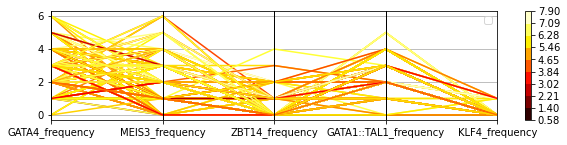

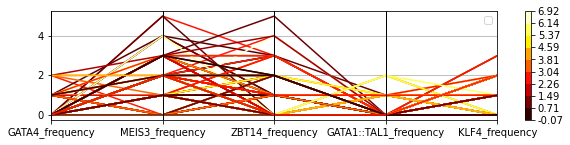

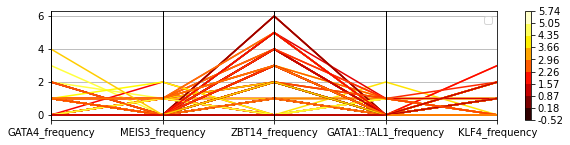

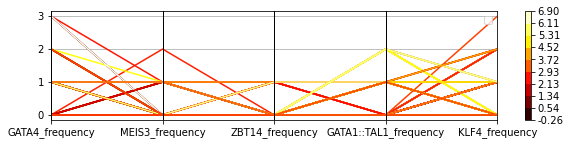

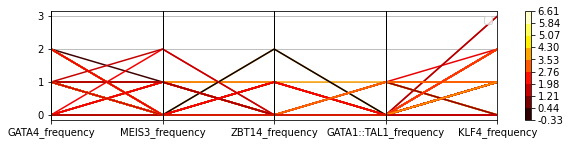

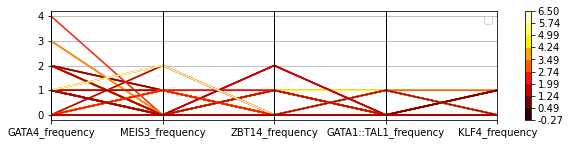

In [536]:
motif_columns = track_df.columns[-5:].tolist()
for round_num in range(0, 6):
    track_round_df = track_df[(track_df['round'] == round_num)].reset_index()
    plot_df = track_round_df[motif_columns + ['OverMax']]
    #plt.figure(figsize=(10,5))
    #pd.plotting.parallel_coordinates(frame=track_round_df, cols=motif_columns, class_column='OverMax')
    parallel_coordinates(plot_df, 'OverMax', colormap="hot")
    
    #plt.show()
    #track_round_df[motif_columns]

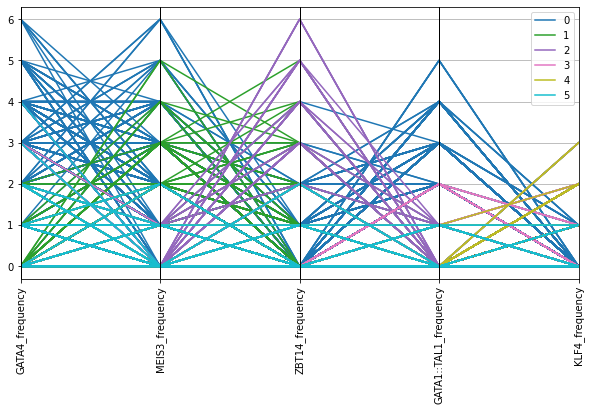

In [537]:
#from pandas.tools.plotting import parallel_coordinates
alphas = track_df['OverMax'] - track_df['OverMax'].min()
alphas = alphas / alphas.max()
alphas = alphas.tolist()

plt.figure(figsize=(10,5))
pd.plotting.parallel_coordinates(frame=track_df, cols=motif_columns, class_column='round', colormap='tab10')
plt.xticks(rotation=90)
plt.show()

In [538]:
track_df

,index,ID,sequence,project,method,round,K562_signal,HepG2_signal,SKNSH_signal,K562_lfcSE,HepG2_lfcSE,SKNSH_lfcSE,K562_ctrl_mean,HepG2_ctrl_mean,SKNSH_ctrl_mean,K562_exp_mean,HepG2_exp_mean,SKNSH_exp_mean,K562_pred,HepG2_pred,SKNSH_pred,K562_pred_aggreg,HepG2_pred_aggreg,SKNSH_pred_aggreg,pred_max_cell,signal_max_cell,target_cell,target_cell_lfc,max_non_target_cell,max_non_target_lfc,min_non_target_cell,min_non_target_lfc,mean_non_target_lfc,OverMean,OverMax,contrib_K562,contrib_HepG2,contrib_SKNSH,penalty_track,GATA4_frequency,MEIS3_frequency,ZBT14_frequency,GATA1::TAL1_frequency,KLF4_frequency
0,6869,20211212_92818__893131__0::fsp__k562__0,GCTGTCAATAGACGTGCGCGCAGCTGTCCACACGCGGGCGAGCCTT...,BODA:k562,fsp,0,4.791016,-0.985970,-0.960359,0.387067,0.374636,0.276942,629.973930,629.973930,629.973930,17442.765247,318.080538,323.789631,6.193643,-1.741304,-1.758882,5.882185,-1.649403,-1.684321,k562,k562,k562,4.791016,sknsh,-0.960359,hepg2,-0.985970,-0.973164,5.764180,5.751375,[-5.64221218e-02 -5.72692938e-02 -8.88955127e-...,[-7.1906015e-02 -7.5108849e-02 -7.8560509e-02 ...,[-5.57445511e-02 -6.77293539e-02 -7.49817565e-...,893131,3,4,2,2,0
1,6870,20211212_92818__893131__2::fsp__k562__0,GCTGCTTATCGCTGAACCACATGCCGTCAGGATCGAGCTGATAAGG...,BODA:k562,fsp,0,4.817953,-0.505497,-1.154045,0.370266,0.294238,0.377227,408.505563,408.505563,408.505563,11523.976836,287.740945,183.465985,7.501083,-1.177009,-1.165744,7.455335,-0.905664,-0.987594,k562,k562,k562,4.817953,hepg2,-0.505497,sknsh,-1.154045,-0.829771,5.647724,5.323450,[ 0.002883978 -0.011772015 0.017439002 0....,[-5.74475266e-02 -4.09115516e-02 -7.86192641e-...,[-4.26512882e-02 -1.85039844e-02 -5.20378910e-...,893131,3,1,0,2,0
2,6871,20211212_92818__893131__3::fsp__k562__0,CCTCATGACAGCTGTCAAACTTGACTGGTTATCCTGCCGCCTCTTA...,BODA:k562,fsp,0,5.565291,-0.546346,-2.051491,0.371360,0.473252,0.691769,206.067259,206.067259,206.067259,9759.780268,141.105721,49.630198,9.619950,-1.462912,-1.622922,9.204848,-1.303670,-1.569874,k562,k562,k562,5.565291,hepg2,-0.546346,sknsh,-2.051491,-1.298919,6.864210,6.111638,[-0.052659187 -0.041627258 -0.067178965 -0....,[-5.41790612e-02 -8.54226127e-02 -6.42349422e-...,[-0.032360386 -0.04514135 -0.052221946 ...,893131,2,3,0,2,0
3,6872,20211212_92818__893131__4::fsp__k562__0,TCGAGGATTAGTGCACCAAAACGGTCGACGCGCCTTATCTTCACCT...,BODA:k562,fsp,0,4.207129,-0.331149,-2.309875,0.331878,0.574262,0.686275,234.978578,234.978578,234.978578,4342.681836,186.785031,47.418060,7.825038,-1.244679,-1.486772,7.321559,-1.106110,-1.335439,k562,k562,k562,4.207129,hepg2,-0.331149,sknsh,-2.309875,-1.320512,5.527641,4.538277,[-1.55510129e-02 -1.60944402e-01 -7.38434643e-...,[-8.50180387e-02 -1.80095583e-01 -6.23949654e-...,[-0.09093956 -0.15059708 -0.031181702 ...,893131,5,0,0,2,0
4,6873,20211212_92818__893131__5::fsp__k562__0,CGCGAAAATTTGACAGCTGCAATACTTAGCCATGATCTTGTTCATG...,BODA:k562,fsp,0,4.953944,-0.420140,-1.012092,0.404382,0.303260,0.223056,1206.454711,1206.454711,1206.454711,37394.275993,901.600667,598.460348,6.638917,-1.284384,-1.313499,6.356563,-1.163809,-1.124818,k562,k562,k562,4.953944,hepg2,-0.420140,sknsh,-1.012092,-0.716116,5.670060,5.374084,[ 0.00072318054 -0.022423988 -0.0075147822 ...,[-0.07931087 -0.053418957 -0.07207999 ...,[-0.0919219 -0.0694985 -0.07463879 ...,893131,3,1,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1664,8533,20211212_92818__893131__1745::fsp__k562__5,TTTCCCAAAGGCAGAACTCCTGTTCCGAACGCCATTCCTAGTATTG...,BODA:k562,fsp,5,3.291349,1.234469,2.356948,0.218116,0.453068,0.157291,144.751153,144.751153,144.751153,1418.632952,340.509297,739.584793,5.182979,1.860475,1.557258,4.962416,2.167621,1.930708,k562,k562,k562,3.291349,sknsh,2.356948,hepg2,1.234469,1.795708,1.495640,0.934401,[ 2.57610008e-02 4.76243487e-03 -9.53809416e-...,[ 2.13260371e-02 -2.02164967e-02 -3.50261070e-...,[-8.97556427e-04 -1.50317117e-03 -1.20271854e-...,893131,0,0

In [696]:
string_vectors = [str(track_df[motif_columns].to_numpy()[row, :]) for row in range(len(track_df))]
track_df['motif_vector'] = string_vectors
uniques, counts = np.unique(string_vectors, return_counts=True)
all_x_ticks = uniques.tolist()
all_counts = counts.tolist()

len(all_x_ticks)

331

In [521]:
def consecutiveRanges(a):
    n = len(a)
    length = 1
    list = []    
    if (n == 0):
        return list    
    for i in range (1, n + 1):
        if (i == n or a[i] -
            a[i - 1] != 1):
            if (length == 1):
                #list.append(str(a[i - length]))
                list.append([a[i - length]])
            else:
#                 temp = (str(a[i - length]) +
#                         " -> " + str(a[i - 1]))
                temp = [a[i - length], a[i - 1]]
                list.append(temp)
            length = 1        
        else:
            length += 1
    return list

all_motif_boxes = []
for i in range(5):
    motif_boxes = [all_x_ticks.index(tick) for tick in all_x_ticks if tick.lstrip('[').rstrip(']').split(' ')[i] != '0']
    all_motif_boxes.append(consecutiveRanges(motif_boxes))

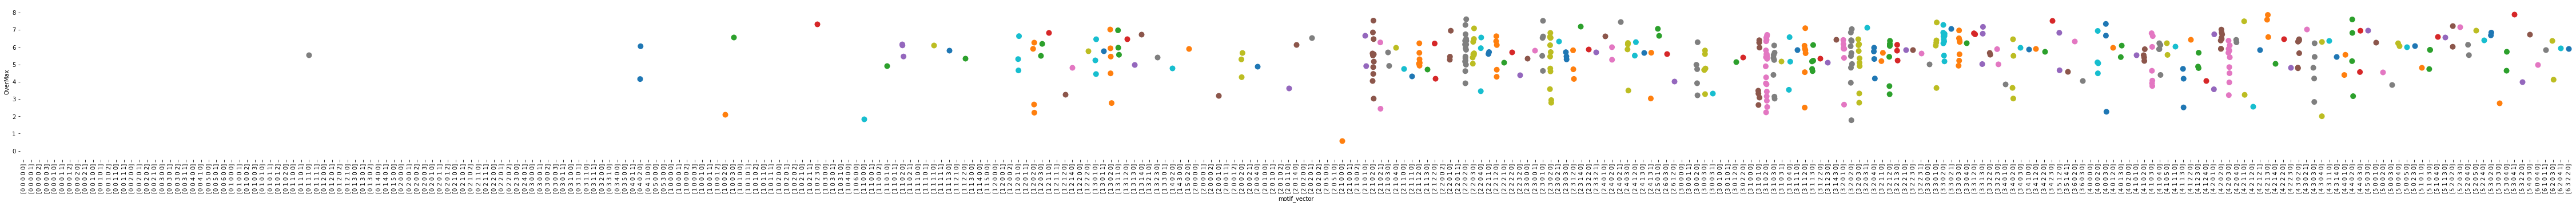

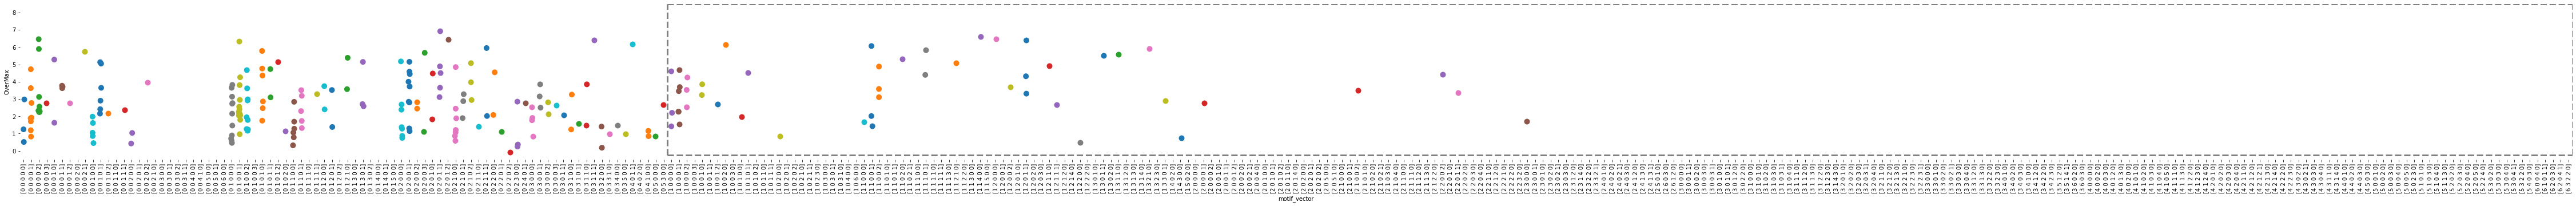

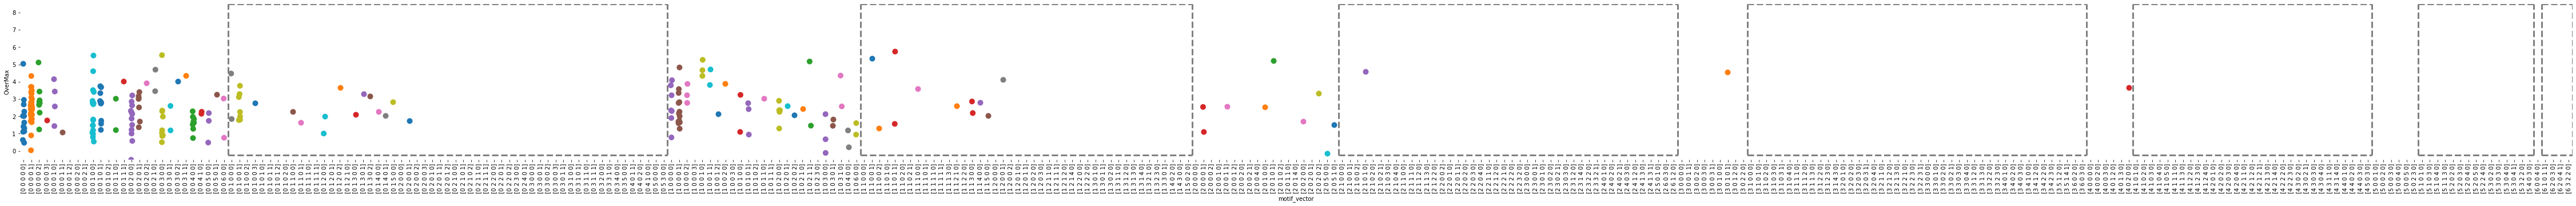

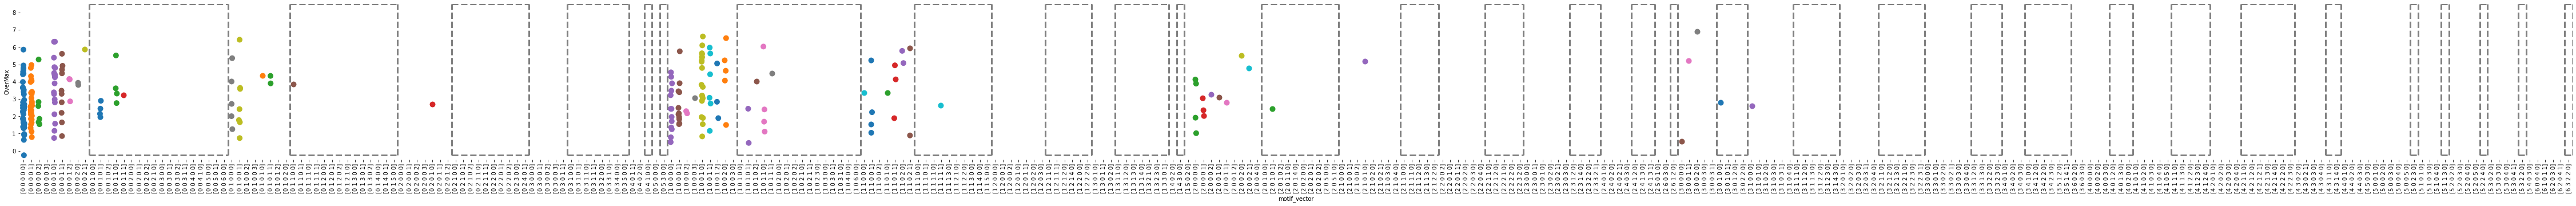

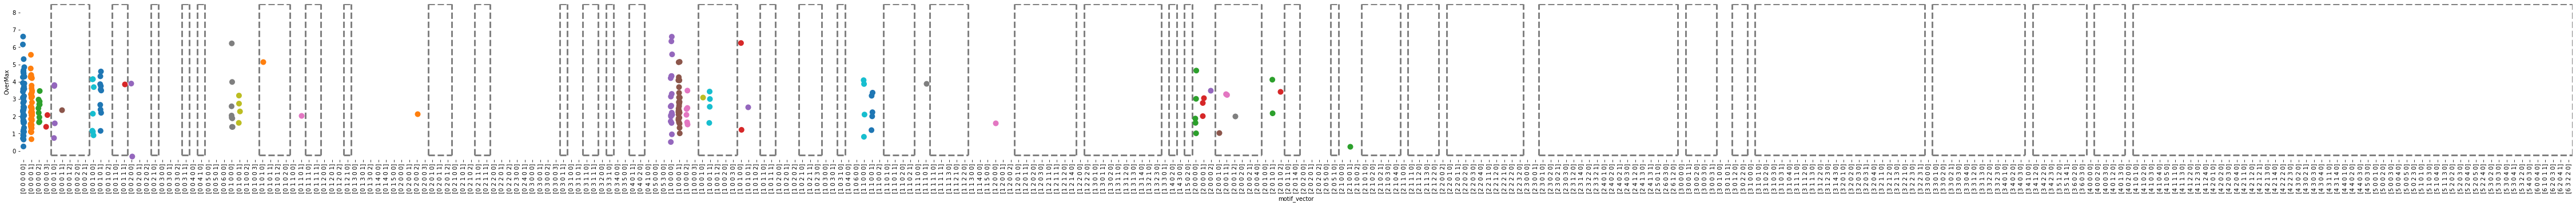

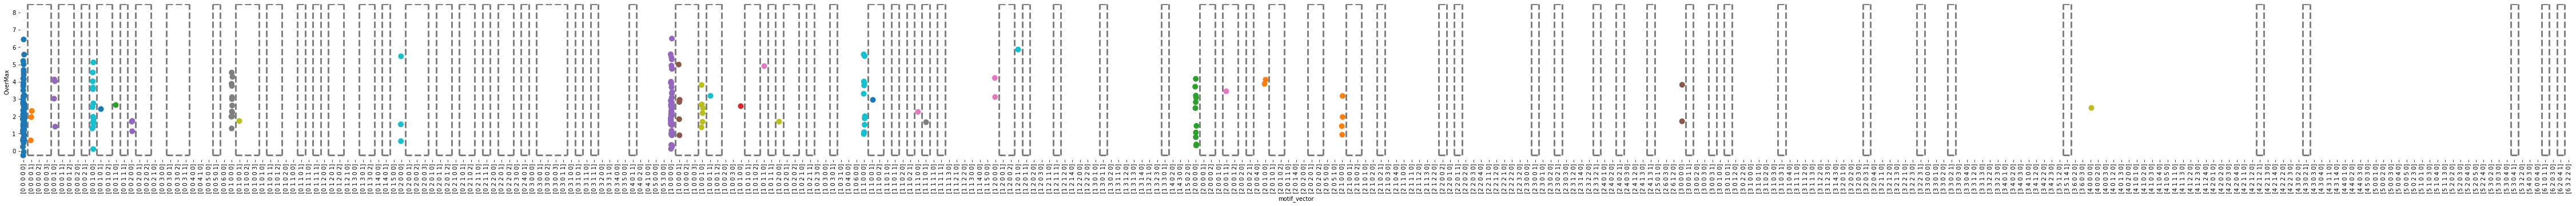

In [526]:
#round_num = 0
for round_num in range(6):
    track_round_df = track_df[(track_df['round'] == round_num)].reset_index()
    
    y_min = -0.5
    y_max = 8.5
    plt.figure(figsize=(80,5))  
    if round_num > 0:
        box_idxs = all_motif_boxes[round_num -1]
        for box in box_idxs:
            box_start = box[0] - 0.5
            box_stop = box[-1] + 0.5
            box_low = y_min + 0.25
            box_top = y_max
            plt.vlines(box_start, box_low, box_top, linestyles='dashed', colors='gray', linewidth=3.0)
            plt.vlines(box_stop, box_low, box_top, linestyles='dashed', colors='gray', linewidth=3.0)
            plt.hlines(box_low, box_start, box_stop, linestyles='dashed', colors='gray', linewidth=3.0)
            plt.hlines(box_top, box_start, box_stop, linestyles='dashed', colors='gray', linewidth=3.0)   
    sns.stripplot(data=track_round_df, x='motif_vector', y='OverMax', order=all_x_ticks, s=10, palette='tab10')    
    plt.box(False)
    plt.xticks(rotation=90)
    plt.ylim(y_min, y_max)  
    plt.show()

In [564]:
zero_idxs = [0, 1, 2, 3, 4]

zero_columns = list(np.array(motif_columns)[zero_idxs])
condition = (track_df[zero_columns[0]] == 0)
for i in range(1, len(zero_columns)):
    condition = condition & (track_df[zero_columns[i]] == 0)
track_df[condition]

,index,ID,sequence,project,method,round,K562_signal,HepG2_signal,SKNSH_signal,K562_lfcSE,HepG2_lfcSE,SKNSH_lfcSE,K562_ctrl_mean,HepG2_ctrl_mean,SKNSH_ctrl_mean,K562_exp_mean,HepG2_exp_mean,SKNSH_exp_mean,K562_pred,HepG2_pred,SKNSH_pred,K562_pred_aggreg,HepG2_pred_aggreg,SKNSH_pred_aggreg,pred_max_cell,signal_max_cell,target_cell,target_cell_lfc,max_non_target_cell,max_non_target_lfc,min_non_target_cell,min_non_target_lfc,mean_non_target_lfc,OverMean,OverMax,contrib_K562,contrib_HepG2,contrib_SKNSH,penalty_track,GATA4_frequency,MEIS3_frequency,ZBT14_frequency,GATA1::TAL1_frequency,KLF4_frequency
568,7437,20211212_92818__893131__605::fsp__k562__1,GCTCCTAGCACGTGCAGGAAATGTCGACGGCTCAATACTGGGGCGC...,BODA:k562,fsp,1,-0.057887,-0.569436,-1.053005,0.191765,0.259090,0.147573,1687.050108,1687.050108,1687.050108,1618.223027,1136.810725,813.314349,1.372340,-1.159810,-0.991512,1.214441,-0.834666,-0.797682,k562,k562,k562,-0.057887,hepg2,-0.569436,sknsh,-1.053005,-0.811221,0.753334,0.511550,[-0.037085924 -0.01876408 -0.023538262 -0....,[-4.66851890e-02 -5.83724566e-02 -7.16646537e-...,[-0.03982091 -0.06189318 -0.04096559 ...,893131,0,0,0,0,0
577,7446,20211212_92818__893131__614::fsp__k562__1,TCTGGGTGCGACAAAGAGTACCCGTCGAGTGAGTTCATCGTGGGGC...,BODA:k562,fsp,1,2.691803,0.965624,1.448018,0.200579,0.317590,0.334484,167.927017,167.927017,167.927017,1089.840764,327.989006,458.501949,5.391144,1.736988,1.561128,5.005903,1.887771,1.544970,k562,k562,k562,2.691803,sknsh,1.448018,hepg2,0.965624,1.206821,1.484982,1.243785,[ 2.51274817e-02 -4.98857759e-02 -2.40273084e-...,[-2.97567658e-02 -8.25904086e-02 -3.97681594e-...,[-0.004926272 -0.05806866 -0.048782967 0....,893131,0,0,0,0,0
656,7525,20211212_92818__893131__696::fsp__k562__1,TCTCCTCAGTGTATACTGTCTTGGGTAACAGGTTTGTAACTATGAT...,BODA:k562,fsp,1,4.251141,1.186130,1.278410,0.263301,0.548586,0.446027,33.332813,33.332813,33.332813,635.422534,75.743432,80.663282,5.493348,1.371760,1.370997,4.749868,1.297329,1.505611,k562,k562,k562,4.251141,sknsh,1.278410,hepg2,1.186130,1.232270,3.018870,2.972730,[ 1.85147431e-02 -3.91175374e-02 -2.68154815e-...,[ 2.66628806e-02 -6.56923726e-02 -6.98454455e-...,[-2.01477390e-02 -6.50564656e-02 -3.80759127e-...,893131,0,0,0,0,0
724,7593,20211212_92818__893131__772::fsp__k562__2,TAGGACACGCCCGCTGCAAGACTAGCAGCATCGTCAATGGCTATTC...,BODA:k562,fsp,2,1.222496,0.757659,0.480366,0.216370,0.256301,0.160300,748.690315,748.690315,748.690315,1749.718227,1265.802074,1044.390901,4.068656,0.818315,0.820704,2.832348,0.906228,1.003151,k562,k562,k562,1.222496,hepg2,0.757659,sknsh,0.480366,0.619012,0.603483,0.464837,[ 1.99081674e-02 4.85139489e-02 1.06267231e-...,[ 3.77667584e-02 1.00058861e-01 5.89934550e-...,[ 3.15217078e-02 9.20118317e-02 6.01479709e-...,893131,0,0,0,0,0
725,7594,20211212_92818__893131__773::fsp__k562__2,TAGCTATTTTTCGCGCCTAATTAGCATGGCGCGACAGGAGCCTACA...,BODA:k562,fsp,2,1.183885,-0.127369,-1.008126,0.179934,0.263671,0.279873,557.437863,557.437863,557.437863,1268.774292,510.313214,277.377411,3.098130,-0.736672,-0.908027,2.668972,-0.633178,-0.741911,k562,k562,k562,1.183885,hepg2,-0.127369,sknsh,-1.008126,-0.567748,1.751633,1.311255,[ 2.11789697e-01 7.56461173e-02 1.72692791e-...,[ 7.5352721e-02 6.8187602e-02 8.4361032e-02 ...,[ 3.49159278e-02 4.00141291e-02 2.84014121e-...,893131,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1658,8527,20211212_92818__893131__1739::fsp__k562__5,TGGCTAAGCTTTCGGACTACACTGGTGACGGGTCCCGAGGTTCCTG...,BODA:k562,fsp,5,4.014446,-0.128922,-0.369499,0.391547,0.248681,0.199647,729.692756,729.692756,729.692756,11794.125433,667.331969,564.694914,5.709047,-0.002305,0.026706,5.079779,0.251552,0.359768,k562,k562,k562,4.014446,hepg2,-0.128922,sknsh,-0.369499,-0.249211,4.263657,4.143368,[ 7.06266090e-02 -1.53718714e-03 2.75498331e-...,[ 7.0603773e-02 2.1925816e-02 4.8060674e-02 ...,[ 0.020598598 0.01761301 0.050181977 ...,893131,0

<AxesSubplot:>

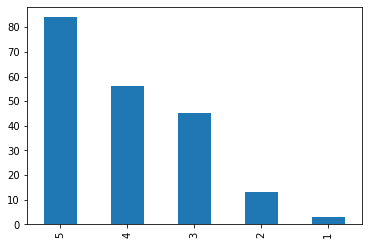

In [575]:
track_df.loc[condition]['round'].value_counts().plot(kind='bar')

In [593]:
binary_string_vectors = [str(1*(track_df[motif_columns] > 0).to_numpy()[row, :]) for row in range(len(track_df))]
track_df['binary_string_vector'] = binary_string_vectors
all_x_ticks = sorted(set(binary_string_vectors))

all_motif_boxes = []
for i in range(5):
    motif_boxes = [all_x_ticks.index(tick) for tick in all_x_ticks if tick.lstrip('[').rstrip(']').split(' ')[i] != '0']
    all_motif_boxes.append(consecutiveRanges(motif_boxes))

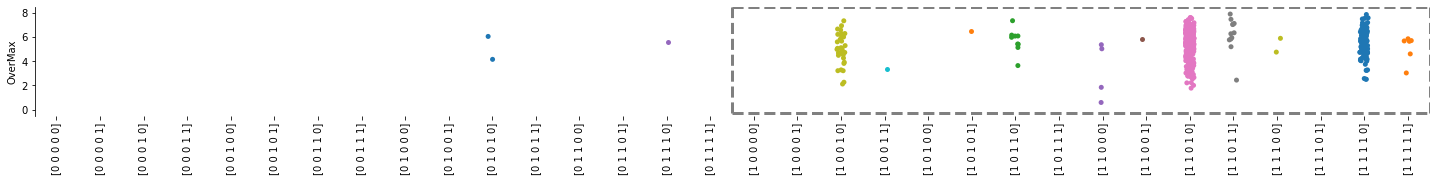

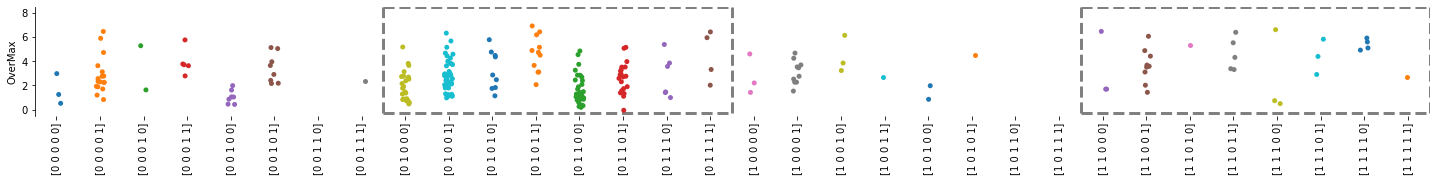

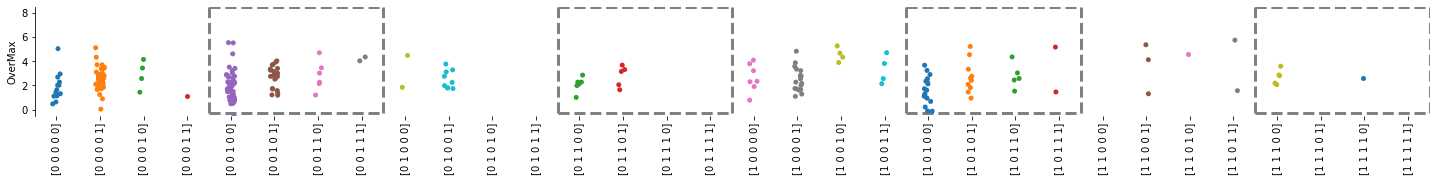

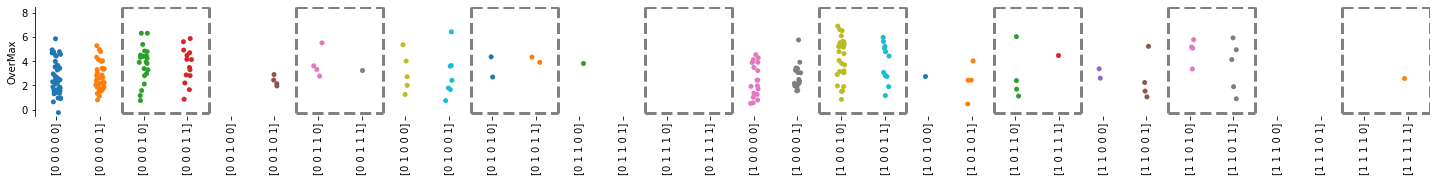

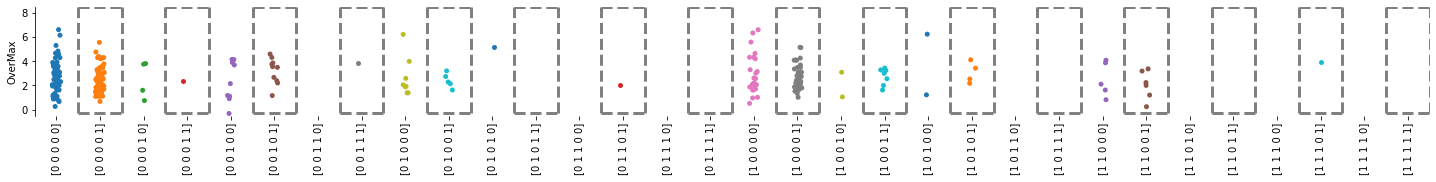

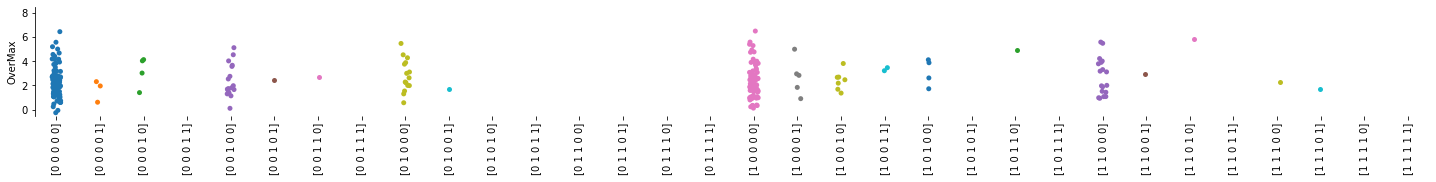

In [623]:
for round_num in range(6):
    track_round_df = track_df[(track_df['round'] == round_num)].reset_index()
    
    y_min = -0.5
    y_max = 8.5
    plt.figure(figsize=(25,2)) 
    if round_num > 0:
        box_idxs = all_motif_boxes[round_num - 1]
#         for box in box_idxs:
#             box_start = box[0] - 0.5
#             box_stop = box[-1] + 0.5
#             box_low = y_min + 0.25
#             box_top = y_max
#             plt.vlines(box_start, box_low, box_top, linestyles='dashed', colors='gray', linewidth=3.0)
#             plt.vlines(box_stop, box_low, box_top, linestyles='dashed', colors='gray', linewidth=3.0)
#             plt.hlines(box_low, box_start, box_stop, linestyles='dashed', colors='gray', linewidth=3.0)
#             plt.hlines(box_top, box_start, box_stop, linestyles='dashed', colors='gray', linewidth=3.0) 
    if round_num < 5:
        box_idxs = all_motif_boxes[round_num]
        for box in box_idxs:
            box_start = box[0] - 0.5
            box_stop = box[-1] + 0.5
            box_low = y_min + 0.25
            box_top = y_max
            plt.vlines(box_start, box_low, box_top, linestyles='dashed', colors='gray', linewidth=3.0)
            plt.vlines(box_stop, box_low, box_top, linestyles='dashed', colors='gray', linewidth=3.0)
            plt.hlines(box_low, box_start, box_stop, linestyles='dashed', colors='gray', linewidth=3.0)
            plt.hlines(box_top, box_start, box_stop, linestyles='dashed', colors='gray', linewidth=3.0) 
            
    sns.stripplot(data=track_round_df, x='binary_string_vector', y='OverMax', order=all_x_ticks, s=5, palette='tab10')  
    #sns.swarmplot(data=track_round_df, x='binary_string_vector', y='OverMax', order=all_x_ticks, s=3, palette='tab10') 
    sns.despine(bottom=True)
    #plt.box(False)
    plt.xticks(rotation=90)
    plt.ylim(y_min, y_max)  
    plt.xlabel('')
    plt.show()

In [628]:
# temp_df = track_df[(track_df['round'] == 5) & (track_df['OverMax'] >= 2.0)]
# for seq_id, seq in zip(temp_df['ID'], temp_df['sequence']):
#     print(f'>{seq_id}')
#     print(seq)

In [650]:
for i in range(6):
    temp_array = track_df[(track_df['round'] == i)][motif_columns].to_numpy()
    num_seqs = temp_array.shape[0]
    pcts = 100 * temp_array.sum(axis=0) / num_seqs
    pcts = np.around(pcts.tolist(), 0).astype(int)
    print(pcts)

[290 199  36 231   4]
[ 23 131  60  24  79]
[ 40  15 133  14  58]
[51 14  9 46 52]
[43 12 12  7 64]
[57 19 13  7  6]


<AxesSubplot:xlabel='binary_string_vector'>

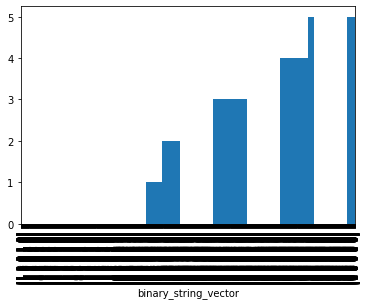

In [653]:
track_df.set_index('binary_string_vector')['round'].plot(kind='bar', stacked=True)

In [659]:
track_df['binary_string_vector'].value_counts(normalize=True, sort=True)

[1 1 0 1 0]    0.175554
[0 0 0 0 0]    0.120431
[0 0 0 0 1]    0.092870
[1 0 0 0 0]    0.073098
[1 1 1 1 0]    0.069503
[1 0 0 0 1]    0.053325
[0 0 1 0 0]    0.050330
[1 0 0 1 0]    0.044937
[0 1 0 0 1]    0.038346
[0 1 0 0 0]    0.031756
[0 0 1 0 1]    0.026962
[0 1 1 0 0]    0.021570
[0 0 0 1 0]    0.020971
[1 1 0 0 0]    0.019173
[1 0 0 1 1]    0.016177
[1 0 1 0 0]    0.016177
[0 1 1 0 1]    0.015578
[1 1 0 0 1]    0.014380
[1 1 0 1 1]    0.014380
[0 0 0 1 1]    0.012582
[1 0 1 0 1]    0.011983
[1 0 1 1 0]    0.011384
[0 1 0 1 0]    0.008388
[0 1 0 1 1]    0.007789
[1 1 1 0 0]    0.006591
[0 0 1 1 0]    0.006591
[1 1 1 1 1]    0.004793
[0 1 1 1 0]    0.004194
[0 0 1 1 1]    0.002996
[1 1 1 0 1]    0.002996
[0 1 1 1 1]    0.002397
[1 0 1 1 1]    0.001797
Name: binary_string_vector, dtype: float64

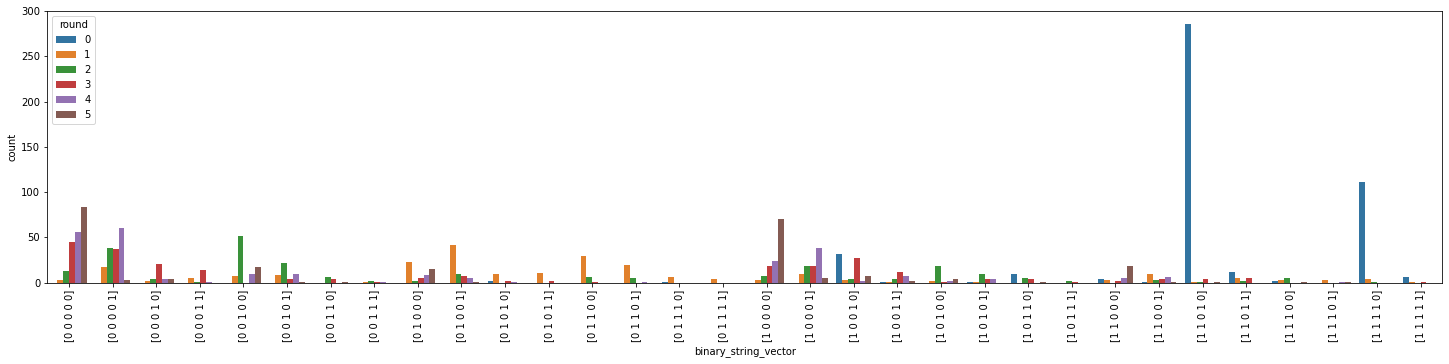

In [665]:
plt.figure(figsize=(25,5)) 
sns.countplot(data=track_df, x='binary_string_vector', hue='round', order=all_x_ticks)
plt.xticks(rotation=90)
plt.show()

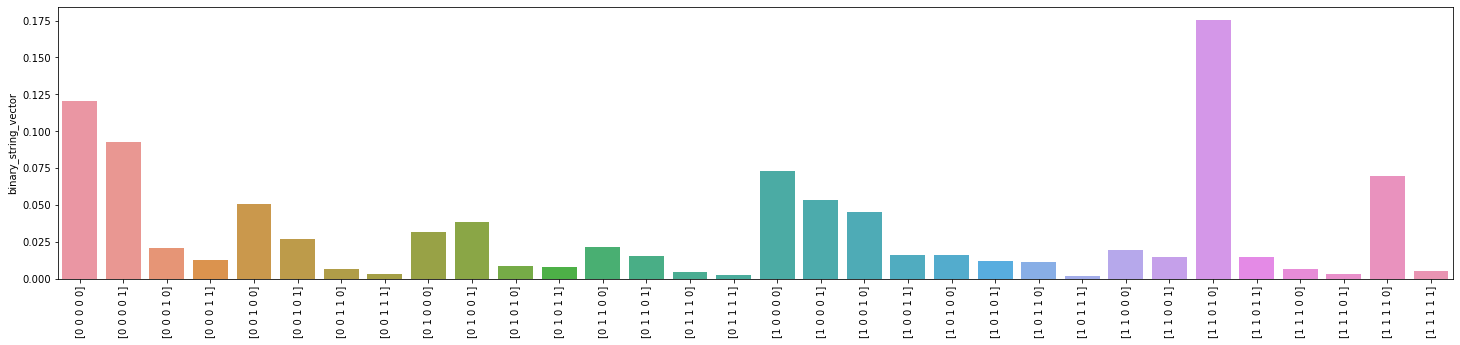

In [668]:
aver = track_df['binary_string_vector'].value_counts(normalize=True, sort=True)

plt.figure(figsize=(25,5)) 
sns.barplot(x=aver.index, y=aver, order=all_x_ticks)
plt.xticks(rotation=90)
plt.show()

0


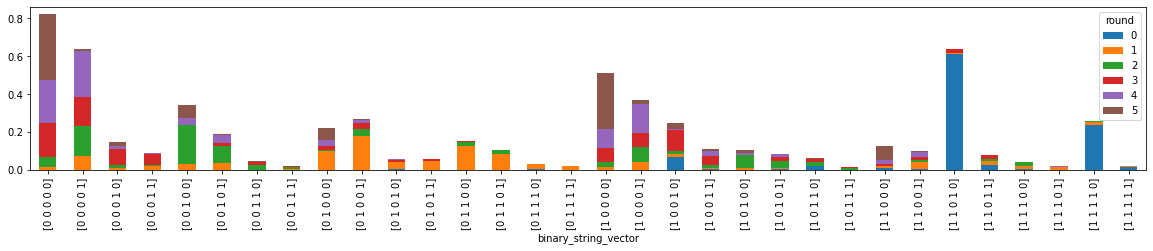

2


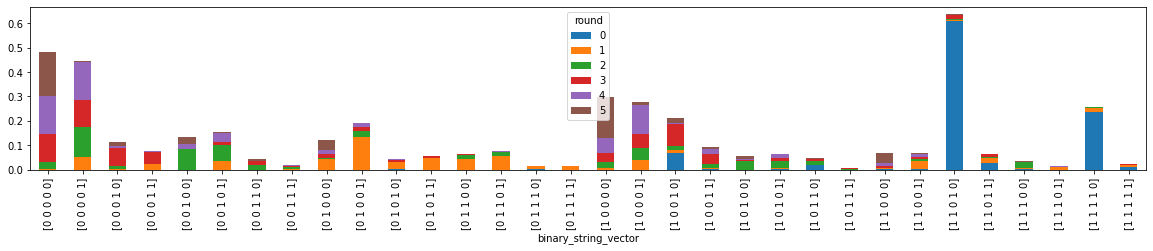

4


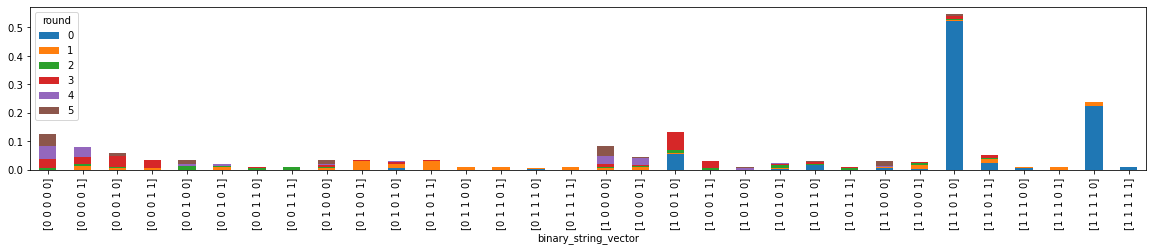

In [706]:
rounds_num_seqs = [len(track_df[track_df['round'] == i]) for i in range(6)]
for overmax in [0, 2, 4]:
    print(overmax)
    temp_df = track_df[track_df['OverMax'] >= overmax]
    df_plot = temp_df.groupby(['round', 'binary_string_vector']).size().reset_index().pivot(columns='round', index='binary_string_vector', values=0)
    #df_plot = df_plot / df_plot.sum(axis=0)
    df_plot = df_plot / rounds_num_seqs
    df_plot.plot(kind='bar', stacked=True, figsize=(20,3))
    plt.show()

In [720]:
temp_df = track_df[track_df['OverMax'] >= 0]
df_plot = temp_df.groupby(['round', 'binary_string_vector']).size().reset_index().pivot(columns='round', index='binary_string_vector', values=0)
#df_plot = df_plot / df_plot.sum(axis=0)
df_plot = df_plot / rounds_num_seqs
df_plot.fillna(0, inplace=True)

# temp_df = track_df[track_df['OverMax'] >= 0]
# df_plot = temp_df.groupby(['round', 'motif_vector']).size().reset_index().pivot(columns='round', index='motif_vector', values=0)
# #df_plot = df_plot / df_plot.sum(axis=0)
# df_plot = df_plot / rounds_num_seqs
# df_plot.fillna(0, inplace=True)

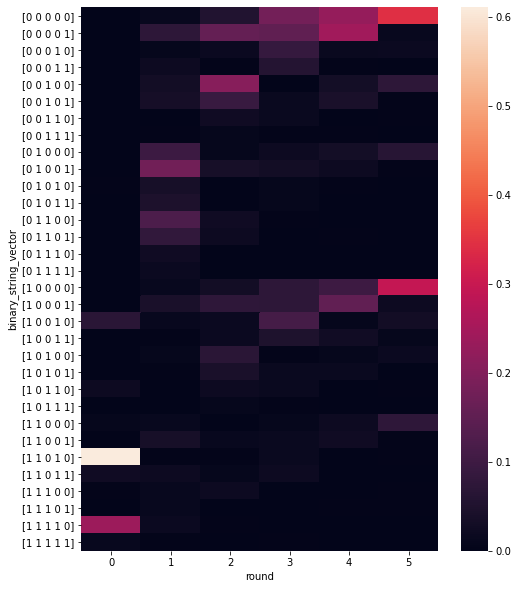

In [725]:
plt.figure(figsize=(8,10)) 
sns.heatmap(df_plot)
plt.show()

In [750]:
match_motif_ids = ['MA0482.2',
                   'MEIS3_HUMAN.H11MO.0.D',
                   'ZBT14_HUMAN.H11MO.0.C',
                   'MA0140.2',
                   'KLF4_HUMAN.H11MO.0.A'                 
                  ]
match_motif_idxs = [tf_df[tf_df['name'] == motif_id].index.item() for motif_id in match_motif_ids]

target_cell = 'k562'

method_subset = ['gs'] #['fsp', 'al', 'sa']

quality_filter = (no_controls_df[['K562_lfcSE', 'HepG2_lfcSE', 'SKNSH_lfcSE']].max(axis=1) <= 1.0) 
genome_df = no_controls_df[quality_filter].copy().reset_index(drop=True)

#--- Genome scan ---
genome_df = genome_df[genome_df['method'].isin(method_subset)].reset_index(drop=True)
genome_df = genome_df[genome_df['target_cell'] == target_cell].reset_index(drop=True)
for match_motif_idx in match_motif_idxs:
    motif_name = tf_df.iloc[match_motif_idx]['short_name']
    temp_filters = torch.Tensor(np.stack([tf_df.iloc[match_motif_idx]['padded_pssm'], tf_df.iloc[match_motif_idx]['padded_pssm_rc']], axis=0))

    score_trheshold = tf_df.iloc[match_motif_idx]['threshold_patser']
    #max_score = tf_df.iloc[match_motif_idx]['max_score']

    track_onehot_sequences = torch.stack([double_pad_seq_tensor(utils.dna2tensor(seq), pad_len=temp_filters.shape[-1]) \
                                              for seq in genome_df['sequence'].tolist()]).type(torch.float32)
    track_scores = F.conv1d(track_onehot_sequences, temp_filters)
    motif_frequencies = (track_scores > score_trheshold).sum(dim=-1).sum(dim=-1).flatten().numpy()
    genome_df[f'{motif_name}_frequency'] = list(motif_frequencies)
genome_df['round'] = 'GS'

genome_binary_string_vectors = [str(1*(genome_df[motif_columns] > 0).to_numpy()[row, :]) for row in range(len(genome_df))]
genome_df['binary_string_vector'] = genome_binary_string_vectors

#--- DHS ---
method_subset = ['DHS']

dhs_df = no_controls_df[quality_filter].copy().reset_index(drop=True)
dhs_df = dhs_df[dhs_df['method'].isin(method_subset)].reset_index(drop=True)
dhs_df = dhs_df[dhs_df['target_cell'] == target_cell].reset_index(drop=True)
for match_motif_idx in match_motif_idxs:
    motif_name = tf_df.iloc[match_motif_idx]['short_name']
    temp_filters = torch.Tensor(np.stack([tf_df.iloc[match_motif_idx]['padded_pssm'], tf_df.iloc[match_motif_idx]['padded_pssm_rc']], axis=0))

    score_trheshold = tf_df.iloc[match_motif_idx]['threshold_patser']
    #max_score = tf_df.iloc[match_motif_idx]['max_score']

    track_onehot_sequences = torch.stack([double_pad_seq_tensor(utils.dna2tensor(seq), pad_len=temp_filters.shape[-1]) \
                                              for seq in dhs_df['sequence'].tolist()]).type(torch.float32)
    track_scores = F.conv1d(track_onehot_sequences, temp_filters)
    motif_frequencies = (track_scores > score_trheshold).sum(dim=-1).sum(dim=-1).flatten().numpy()
    dhs_df[f'{motif_name}_frequency'] = list(motif_frequencies)
dhs_df['round'] = 'DHS'

dhs_binary_string_vectors = [str(1*(dhs_df[motif_columns] > 0).to_numpy()[row, :]) for row in range(len(dhs_df))]
dhs_df['binary_string_vector'] = dhs_binary_string_vectors

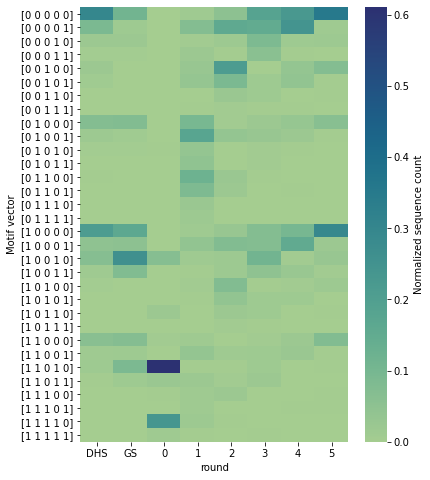

In [858]:
temp_df = pd.concat([track_df, genome_df, dhs_df])
column_order = ['DHS', 'GS', *range(6)]
rounds_num_seqs = [len(temp_df[temp_df['round'] == i]) for i in column_order]

# for overmax in [0]:#, 2, 4]:
#     print(overmax)
df_plot = temp_df.copy()#[temp_df['OverMax'] >= overmax]
df_plot = df_plot.groupby(['round', 'binary_string_vector']).size().reset_index().pivot(columns='round', index='binary_string_vector', values=0)
#df_plot = df_plot / df_plot.sum(axis=0)
df_plot = df_plot[column_order] / rounds_num_seqs
df_plot.fillna(0, inplace=True)

plt.figure(figsize=(6,8)) 
sns.heatmap(df_plot, yticklabels=True, cmap='crest', cbar_kws={'label': 'Normalized sequence count'})
plt.ylabel('Motif vector')
plt.show()

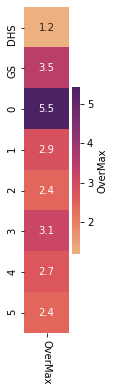

In [856]:
#column_order.reverse()
rounds_overmax_means = [temp_df[temp_df['round'] == i]['OverMax'].mean() for i in column_order]

mean_df = pd.DataFrame({'OverMax': rounds_overmax_means}, index=[str(x) for x in column_order])
plt.figure(figsize=(1,6)) 
sns.heatmap(mean_df, annot=True, cmap='flare', cbar_kws={'label': 'OverMax'})
plt.xticks(rotation=270)
plt.yticks(rotation=90)
plt.show()

#column_order.reverse()

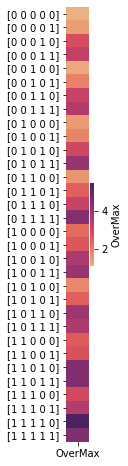

In [857]:
vector_order = df_plot.index.tolist()
vector_overmax_means = [temp_df[temp_df['binary_string_vector'] == i]['OverMax'].mean() for i in vector_order]

mean_df = pd.DataFrame({'OverMax': vector_overmax_means}, index=[str(x) for x in vector_order])
plt.figure(figsize=(0.5,8)) 
sns.heatmap(mean_df, yticklabels=True, cmap='flare', cbar_kws={'label': 'OverMax'})
plt.yticks(rotation=0)
plt.show()


In [861]:
# file_path = f'BODA_fsp_penalization_{track_id}.fa'
# with open(file_path, "w") as f:
#     for ID, seq in zip(track_df['ID'], track_df['sequence']):
#         f.write(">" + ID + "\n" + seq + "\n")

In [864]:
track_id

'893131'